# Проект: Клиенты Телеком

## задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Исследовательский анализ данных

In [1]:
import os
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

!pip install ydata-profiling -q
from ydata_profiling import ProfileReport
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

!pip install lightgbm -q
from lightgbm import LGBMClassifier
!pip install catboost -q
from catboost import CatBoostClassifier, Pool

In [2]:
#функция открывает csv файлы , на вход принемает строку с названием файла
def open_file (file_name):
    path_1 = '/datasets/' + file_name
    path_2 = file_name

    if os.path.exists(path_1):
        data = pd.read_csv(path_1)
    elif os.path.exists(path_2):
        data = pd.read_csv(path_2)
    else:
        'Something is wrong in ' + file_name

    return data


In [3]:
contract_data = open_file('contract_new.csv')
personal_data = open_file('personal_new.csv')
internet_data = open_file('internet_new.csv')
phone_data = open_file('phone_new.csv')

In [4]:
profil = ProfileReport(contract_data, title='Data Profiling')
profil

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

- Есть 11 пропусков в колонке TotalCharges, дубликатов в датафрейме нет 
- есть небольшая корреляция в колонке `Type`(тип оплаты помесячная/годовая/2года) и `BeginDate`(дата начала окозания услуг)
- в колонках с датами и `TotalCharges`(общая сумма расходов) тип данных `object`

In [5]:
profil = ProfileReport(personal_data, title='Data Profiling')
profil

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

- Пропусков и дубликатов в датафрейме нет 
- Видно корреляцию между наличием партнера и еждивенцами (что впринцепи логично)

In [6]:
profil = ProfileReport(internet_data, title='Data Profiling')
profil

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

- Пропусков и дубликатов в датафрейме нет 
- Есть корреляция между колонками `StreamingTV` и `StreamingMovies`

In [7]:
profil = ProfileReport(phone_data, title='Data Profiling')
profil

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

- Пропусков и дубликатов в датафрейме нет 

In [8]:
personal_data['customerID'].isin(internet_data['customerID']).value_counts()

True     5517
False    1526
Name: customerID, dtype: int64

In [9]:
personal_data['customerID'].isin(phone_data['customerID']).value_counts()

True     6361
False     682
Name: customerID, dtype: int64

In [10]:
phone_data['customerID'].isin(internet_data['customerID']).value_counts()

True     4835
False    1526
Name: customerID, dtype: int64

- 4835 пользователей пользуются и услугами интернета, и услугами телефонии

In [11]:
#функция создает целевой признак из колонки с датой окончания обслуживания
def alert(row):
    if row['EndDate'] == 'No':
        return 0
    else:
        return 1

contract_data['left'] = contract_data.apply(alert, axis=1)

In [12]:
contract_data.head(20)

customerID   BeginDate     EndDate            Type PaperlessBilling  \
0   7590-VHVEG  2020-01-01          No  Month-to-month              Yes   
1   5575-GNVDE  2017-04-01          No        One year               No   
2   3668-QPYBK  2019-10-01          No  Month-to-month              Yes   
3   7795-CFOCW  2016-05-01          No        One year               No   
4   9237-HQITU  2019-09-01          No  Month-to-month              Yes   
5   9305-CDSKC  2019-03-01          No  Month-to-month              Yes   
6   1452-KIOVK  2018-04-01          No  Month-to-month              Yes   
7   6713-OKOMC  2019-04-01          No  Month-to-month               No   
8   7892-POOKP  2017-07-01          No  Month-to-month              Yes   
9   6388-TABGU  2014-12-01  2017-05-01        One year               No   
10  9763-GRSKD  2019-01-01          No  Month-to-month              Yes   
11  7469-LKBCI  2018-10-01          No        Two year               No   
12  8091-TTVAX  2015-04-01          No        One year               No   
13  0280-XJGEX  2015-09-01          No  Month-to-month              Yes   
14  5129-JLPIS  2018-01-01          No  Month-to-month              Yes   
15  3655-SNQYZ  2014-05-01  2016-03-01        Two year               No   
16  8191-XWSZG  2015-10-01          No        One year               No   
17  9959-WOFKT  2014-03-01          No        Two year               No   
18  4190-MFLUW  2019-01-01          No  Month-to-month               No   
19  4183-MYFRB  2018-05-01          No  Month-to-month              Yes   

                PaymentMethod  MonthlyCharges TotalCharges  left  
0            Electronic check           29.85        31.04     0  
1                Mailed check           56.95      2071.84     0  
2                Mailed check           53.85       226.17     0  
3   Bank transfer (automatic)           42.30       1960.6     0  
4            Electronic check           70.70        353.5     0  
5            Electronic check           99.65      1150.96     0  
6     Credit card (automatic)           89.10      2058.21     0  
7                Mailed check           29.75       300.48     0  
8            Electronic check          104.80      3573.68     0  
9   Bank transfer (automatic)           56.15      1628.35     1  
10               Mailed check           49.95       649.35     0  
11    Credit card (automatic)           18.95        312.3     0  
12    Credit card (automatic)          100.35      6111.31     0  
13  Bank transfer (automatic)          103.70       5496.1     0  
14           Electronic check          105.50       2637.5     0  
15    Credit card (automatic)          113.25       2491.5     1  
16               Mailed check           20.65      1106.01     0  
17  Bank transfer (automatic)          106.70      8257.51     0  
18    Credit card (automatic)           55.20       789.36     0  
19           Electronic check           90.05      1891.05     0

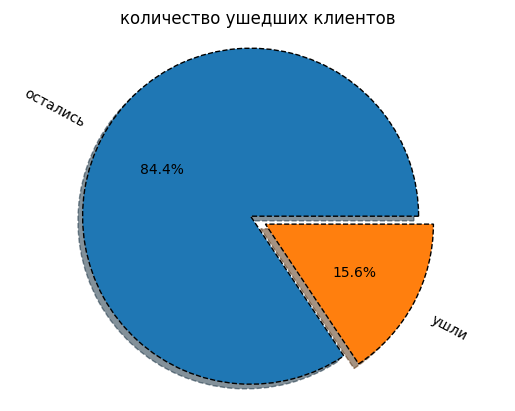

In [13]:
vals = [len(contract_data[contract_data['left']== 0]), len(contract_data[contract_data['left']== 1])]
labels = ['остались', 'ушли']
explode = (0.1, 0)
fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.1f%%', shadow=True, explode=explode, wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"}, rotatelabels=True)
ax.axis("equal")
ax.title.set_text('количество ушедших клиентов')

- отток клиентов за все время составил 15,6 %
- есть дисбаланс в целевом признаке

In [14]:
# функция выводит на экран среднее, медианное, квантили и "ящик с усами"
def plotbox (data, column):
    print(data[column].describe())
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.boxplot(x = column , data = data, ).set_title(column)  

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64


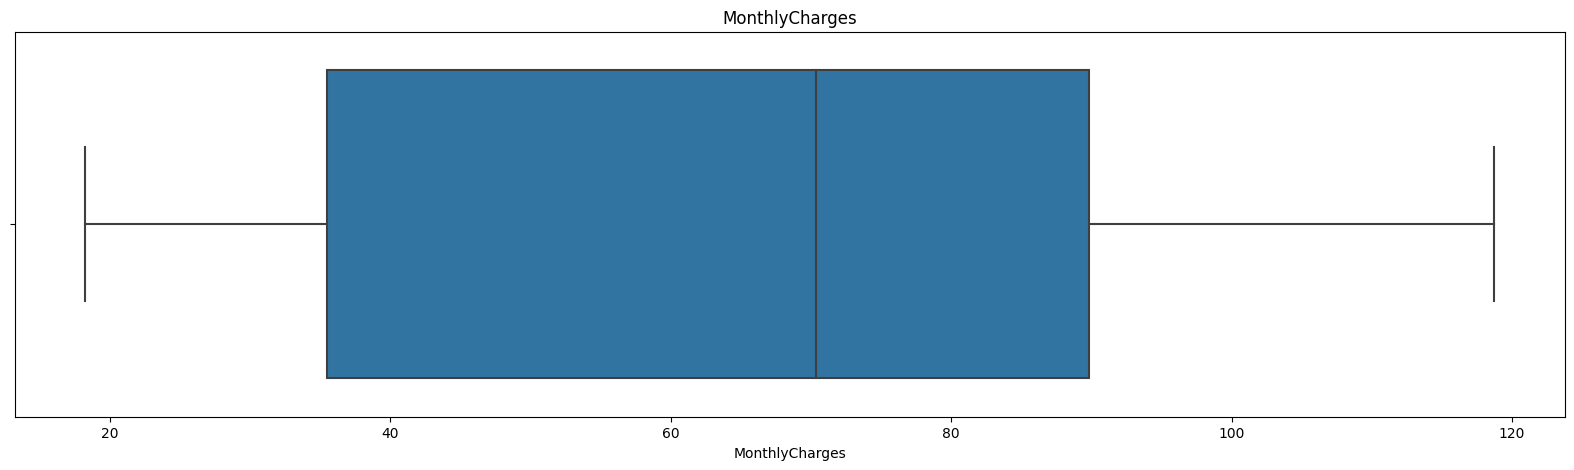

In [15]:
plotbox(contract_data, 'MonthlyCharges')

count    7032.000000
mean     2118.621822
std      2112.736199
min        19.050000
25%       439.745000
50%      1345.275000
75%      3239.317500
max      9221.380000
Name: TotalCharges, dtype: float64


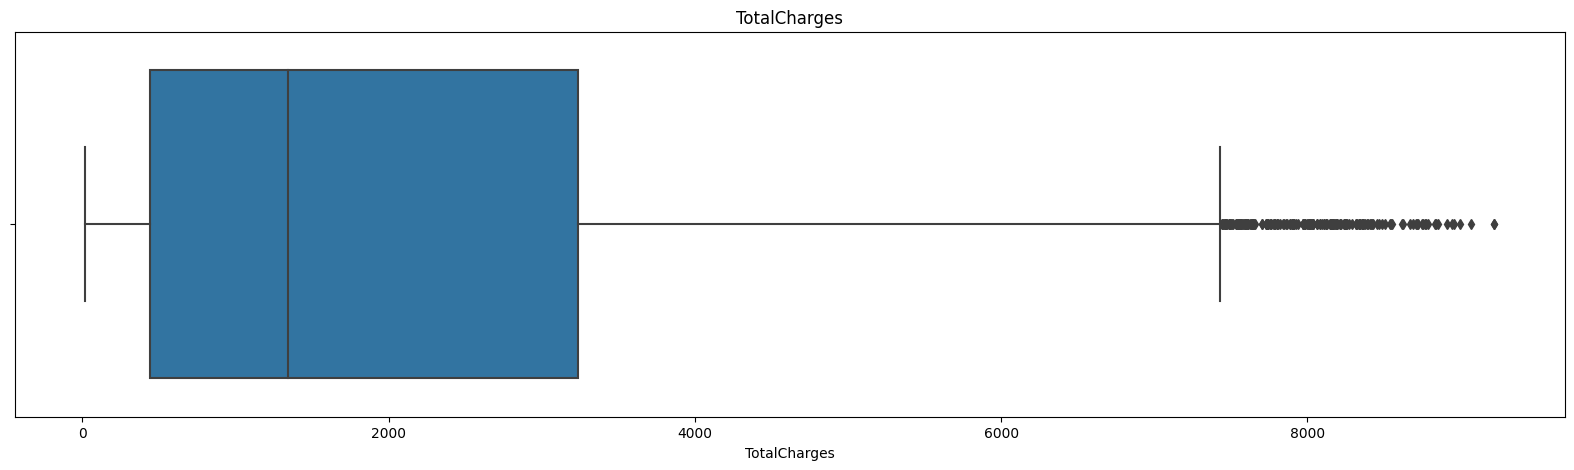

In [16]:
contract_data['TotalCharges'] = pd.to_numeric(contract_data['TotalCharges'], errors='coerce')
plotbox(contract_data, 'TotalCharges')

- есть вбросы в общей сумме платежей

### Вывод :
1. В датафреймах нет пропусков и дубликатов
2. Есть небольшая корреляция в данных
3. Есть несоответствующие типы данных колонкам
4. 4835 пользователе пользуются и интернетом, и телефонией 
5. Целевой признак - завершение обслуживания 
6. В целевом признаке есть дисбаланс классов ~ 84/16 (остались/ушли)
7. Есть аномальные значения в колонке `contract_data['TotalCharges']`
8. Больше всего людей предпочитают ежемесечную оплату, но почемуто людей взявших контракт на 2 года больше, чем людей взявших на год

### Список уточняющих вопросов :

1. Нужно ли приводить колонки с датой к типу date ?
2. Целевой признак строится по столбцу `contract_data['EndDate']` ?
3. Колонка `contract_data['PaperlessBilling']` - что это ?
4. В каких еденицах измеряются платежи ?

<div class="alert alert-success">
<b>Комментарий тимлида:</b> 
    
1. Зависит от твоих дальнейших шагов, что ты с этими признаками собираешься делать.
    
    
2. Да, все верно!
    
    
3. Выставляется ли счет клиенту электронно, или присылается бумажная версия квитанции.
    
    
4. Можно считать, что в условных, это не принципиально для задачи.

### План решения задачи :
1. Предобработать данные 
2. Составить портрет уходящего клиента
3. подготовить df к обучению (тест-трейнб, кодирование, масштабирование)
4. обучить несколько моделий, подбор параметров
5. выделить важные/неважные признаки
3. написать вывод 

### Цель проекта :
- Выявить клиентов которые потенциально могут отказаться от услуг компании 

# обработка данных

In [17]:
contract_data['TotalCharges'].isna().sum()

11

In [18]:
df1 = contract_data[contract_data['TotalCharges'].isna()]
df1.head()

customerID   BeginDate EndDate      Type PaperlessBilling  \
488   4472-LVYGI  2020-02-01      No  Two year              Yes   
753   3115-CZMZD  2020-02-01      No  Two year               No   
936   5709-LVOEQ  2020-02-01      No  Two year               No   
1082  4367-NUYAO  2020-02-01      No  Two year               No   
1340  1371-DWPAZ  2020-02-01      No  Two year               No   

                  PaymentMethod  MonthlyCharges  TotalCharges  left  
488   Bank transfer (automatic)           52.55           NaN     0  
753                Mailed check           20.25           NaN     0  
936                Mailed check           80.85           NaN     0  
1082               Mailed check           25.75           NaN     0  
1340    Credit card (automatic)           56.05           NaN     0

In [19]:
contract_data['TotalCharges'] = contract_data['TotalCharges']. fillna(contract_data['MonthlyCharges'])

In [20]:
contract_data['TotalCharges'].isna().sum()

0

- заменил пропуски в `contract_data['TotalCharges']` на значения из колонки `contract_data['MonthlyCharges']`, \
так как скорее всего пропуски у тех людей, которые пришли в последний месяц и их оплата не успела попасть в базу 

In [21]:
data = contract_data.set_index('customerID').join(phone_data.set_index('customerID'))
data = data.join(personal_data.set_index('customerID'))
data = data.join(internet_data.set_index('customerID'))

In [22]:
data.isnull().sum()

BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
left                   0
MultipleLines        682
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
dtype: int64

In [23]:
data['MultipleLines'] = data['MultipleLines'].fillna("Usen't")

data.head(20)

BeginDate     EndDate            Type PaperlessBilling  \
customerID                                                            
7590-VHVEG  2020-01-01          No  Month-to-month              Yes   
5575-GNVDE  2017-04-01          No        One year               No   
3668-QPYBK  2019-10-01          No  Month-to-month              Yes   
7795-CFOCW  2016-05-01          No        One year               No   
9237-HQITU  2019-09-01          No  Month-to-month              Yes   
9305-CDSKC  2019-03-01          No  Month-to-month              Yes   
1452-KIOVK  2018-04-01          No  Month-to-month              Yes   
6713-OKOMC  2019-04-01          No  Month-to-month               No   
7892-POOKP  2017-07-01          No  Month-to-month              Yes   
6388-TABGU  2014-12-01  2017-05-01        One year               No   
9763-GRSKD  2019-01-01          No  Month-to-month              Yes   
7469-LKBCI  2018-10-01          No        Two year               No   
8091-TTVAX  2015-04-01          No        One year               No   
0280-XJGEX  2015-09-01          No  Month-to-month              Yes   
5129-JLPIS  2018-01-01          No  Month-to-month              Yes   
3655-SNQYZ  2014-05-01  2016-03-01        Two year               No   
8191-XWSZG  2015-10-01          No        One year               No   
9959-WOFKT  2014-03-01          No        Two year               No   
4190-MFLUW  2019-01-01          No  Month-to-month               No   
4183-MYFRB  2018-05-01          No  Month-to-month              Yes   

                        PaymentMethod  MonthlyCharges  TotalCharges  left  \
customerID                                                                  
7590-VHVEG           Electronic check           29.85         31.04     0   
5575-GNVDE               Mailed check           56.95       2071.84     0   
3668-QPYBK               Mailed check           53.85        226.17     0   
7795-CFOCW  Bank transfer (automatic)           42.30       1960.60     0   
9237-HQITU           Electronic check           70.70        353.50     0   
9305-CDSKC           Electronic check           99.65       1150.96     0   
1452-KIOVK    Credit card (automatic)           89.10       2058.21     0   
6713-OKOMC               Mailed check           29.75        300.48     0   
7892-POOKP           Electronic check          104.80       3573.68     0   
6388-TABGU  Bank transfer (automatic)           56.15       1628.35     1   
9763-GRSKD               Mailed check           49.95        649.35     0   
7469-LKBCI    Credit card (automatic)           18.95        312.30     0   
8091-TTVAX    Credit card (automatic)          100.35       6111.31     0   
0280-XJGEX  Bank transfer (automatic)          103.70       5496.10     0   
5129-JLPIS           Electronic check          105.50       2637.50     0   
3655-SNQYZ    Credit card (automatic)          113.25       2491.50     1   
8191-XWSZG               Mailed check           20.65       1106.01     0   
9959-WOFKT  Bank transfer (automatic)          106.70       8257.51     0   
4190-MFLUW    Credit card (automatic)           55.20        789.36     0   
4183-MYFRB           Electronic check           90.05       1891.05     0   

           MultipleLines  gender  SeniorCitizen Partner Dependents  \
customerID                                                           
7590-VHVEG        Usen't  Female              0     Yes         No   
5575-GNVDE            No    Male              0      No         No   
3668-QPYBK            No    Male              0      No         No   
7795-CFOCW        Usen't    Male              0      No         No   
9237-HQITU            No  Female              0      No         No   
9305-CDSKC           Yes  Female              0      No         No   
1452-KIOVK           Yes    Male              0      No        Yes   
6713-OKOMC        Usen't  Female              0      No         No   
7892-POOKP           Yes  Female              0     Yes

In [24]:
data['additional_services'] = 0
#Цикл заполняет столбец additional_services значением Yes если хоть в одной колонке с сервисами есть Yes
for i in list(data):
    if data[i].isnull().sum() > 0 :
        data.loc[data[i] == 'Yes', 'additional_services'] += 1
        

data.head(20)

BeginDate     EndDate            Type PaperlessBilling  \
customerID                                                            
7590-VHVEG  2020-01-01          No  Month-to-month              Yes   
5575-GNVDE  2017-04-01          No        One year               No   
3668-QPYBK  2019-10-01          No  Month-to-month              Yes   
7795-CFOCW  2016-05-01          No        One year               No   
9237-HQITU  2019-09-01          No  Month-to-month              Yes   
9305-CDSKC  2019-03-01          No  Month-to-month              Yes   
1452-KIOVK  2018-04-01          No  Month-to-month              Yes   
6713-OKOMC  2019-04-01          No  Month-to-month               No   
7892-POOKP  2017-07-01          No  Month-to-month              Yes   
6388-TABGU  2014-12-01  2017-05-01        One year               No   
9763-GRSKD  2019-01-01          No  Month-to-month              Yes   
7469-LKBCI  2018-10-01          No        Two year               No   
8091-TTVAX  2015-04-01          No        One year               No   
0280-XJGEX  2015-09-01          No  Month-to-month              Yes   
5129-JLPIS  2018-01-01          No  Month-to-month              Yes   
3655-SNQYZ  2014-05-01  2016-03-01        Two year               No   
8191-XWSZG  2015-10-01          No        One year               No   
9959-WOFKT  2014-03-01          No        Two year               No   
4190-MFLUW  2019-01-01          No  Month-to-month               No   
4183-MYFRB  2018-05-01          No  Month-to-month              Yes   

                        PaymentMethod  MonthlyCharges  TotalCharges  left  \
customerID                                                                  
7590-VHVEG           Electronic check           29.85         31.04     0   
5575-GNVDE               Mailed check           56.95       2071.84     0   
3668-QPYBK               Mailed check           53.85        226.17     0   
7795-CFOCW  Bank transfer (automatic)           42.30       1960.60     0   
9237-HQITU           Electronic check           70.70        353.50     0   
9305-CDSKC           Electronic check           99.65       1150.96     0   
1452-KIOVK    Credit card (automatic)           89.10       2058.21     0   
6713-OKOMC               Mailed check           29.75        300.48     0   
7892-POOKP           Electronic check          104.80       3573.68     0   
6388-TABGU  Bank transfer (automatic)           56.15       1628.35     1   
9763-GRSKD               Mailed check           49.95        649.35     0   
7469-LKBCI    Credit card (automatic)           18.95        312.30     0   
8091-TTVAX    Credit card (automatic)          100.35       6111.31     0   
0280-XJGEX  Bank transfer (automatic)          103.70       5496.10     0   
5129-JLPIS           Electronic check          105.50       2637.50     0   
3655-SNQYZ    Credit card (automatic)          113.25       2491.50     1   
8191-XWSZG               Mailed check           20.65       1106.01     0   
9959-WOFKT  Bank transfer (automatic)          106.70       8257.51     0   
4190-MFLUW    Credit card (automatic)           55.20        789.36     0   
4183-MYFRB           Electronic check           90.05       1891.05     0   

           MultipleLines  gender  ...  Partner Dependents InternetService  \
customerID                        ...                                       
7590-VHVEG        Usen't  Female  ...      Yes         No             DSL   
5575-GNVDE            No    Male  ...       No         No             DSL   
3668-QPYBK            No    Male  ...       No         No             DSL   
7795-CFOCW        Usen't    Male  ...       No         No             DSL   
9237-HQITU            No  Female  ...       No         No     Fiber optic   
9305-CDSKC           Yes  Female  ...       No         No     Fiber optic   
1452-KIOVK           Yes    Male  ...       No        Yes     Fiber optic   
6713-OKOMC        Usen't  Female  ...       No         No     

In [25]:
#data = data.fillna("Usen't")
#data.loc[data['InternetService'] == "Usen't", 'additional_services'] = "Usen't"
#data['additional_services'] = data['additional_services'].astype(str)
#data.head(20)

In [26]:
data['SeniorCitizen'].unique()

array([0, 1], dtype=int64)

In [27]:
data.loc[data['SeniorCitizen'] == 0, 'SeniorCitizen'] = 'No'
data.loc[data['SeniorCitizen'] == 1, 'SeniorCitizen'] = 'Yes'

In [28]:
data['SeniorCitizen']

customerID
7590-VHVEG     No
5575-GNVDE     No
3668-QPYBK     No
7795-CFOCW     No
9237-HQITU     No
             ... 
6840-RESVB     No
2234-XADUH     No
4801-JZAZL     No
8361-LTMKD    Yes
3186-AJIEK     No
Name: SeniorCitizen, Length: 7043, dtype: object

In [29]:
data.index.duplicated().sum()

0

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BeginDate            7043 non-null   object 
 1   EndDate              7043 non-null   object 
 2   Type                 7043 non-null   object 
 3   PaperlessBilling     7043 non-null   object 
 4   PaymentMethod        7043 non-null   object 
 5   MonthlyCharges       7043 non-null   float64
 6   TotalCharges         7043 non-null   float64
 7   left                 7043 non-null   int64  
 8   MultipleLines        7043 non-null   object 
 9   gender               7043 non-null   object 
 10  SeniorCitizen        7043 non-null   object 
 11  Partner              7043 non-null   object 
 12  Dependents           7043 non-null   object 
 13  InternetService      5517 non-null   object 
 14  OnlineSecurity       5517 non-null   object 
 15  OnlineBackup         5517 no

In [31]:
data.head(20)

BeginDate     EndDate            Type PaperlessBilling  \
customerID                                                            
7590-VHVEG  2020-01-01          No  Month-to-month              Yes   
5575-GNVDE  2017-04-01          No        One year               No   
3668-QPYBK  2019-10-01          No  Month-to-month              Yes   
7795-CFOCW  2016-05-01          No        One year               No   
9237-HQITU  2019-09-01          No  Month-to-month              Yes   
9305-CDSKC  2019-03-01          No  Month-to-month              Yes   
1452-KIOVK  2018-04-01          No  Month-to-month              Yes   
6713-OKOMC  2019-04-01          No  Month-to-month               No   
7892-POOKP  2017-07-01          No  Month-to-month              Yes   
6388-TABGU  2014-12-01  2017-05-01        One year               No   
9763-GRSKD  2019-01-01          No  Month-to-month              Yes   
7469-LKBCI  2018-10-01          No        Two year               No   
8091-TTVAX  2015-04-01          No        One year               No   
0280-XJGEX  2015-09-01          No  Month-to-month              Yes   
5129-JLPIS  2018-01-01          No  Month-to-month              Yes   
3655-SNQYZ  2014-05-01  2016-03-01        Two year               No   
8191-XWSZG  2015-10-01          No        One year               No   
9959-WOFKT  2014-03-01          No        Two year               No   
4190-MFLUW  2019-01-01          No  Month-to-month               No   
4183-MYFRB  2018-05-01          No  Month-to-month              Yes   

                        PaymentMethod  MonthlyCharges  TotalCharges  left  \
customerID                                                                  
7590-VHVEG           Electronic check           29.85         31.04     0   
5575-GNVDE               Mailed check           56.95       2071.84     0   
3668-QPYBK               Mailed check           53.85        226.17     0   
7795-CFOCW  Bank transfer (automatic)           42.30       1960.60     0   
9237-HQITU           Electronic check           70.70        353.50     0   
9305-CDSKC           Electronic check           99.65       1150.96     0   
1452-KIOVK    Credit card (automatic)           89.10       2058.21     0   
6713-OKOMC               Mailed check           29.75        300.48     0   
7892-POOKP           Electronic check          104.80       3573.68     0   
6388-TABGU  Bank transfer (automatic)           56.15       1628.35     1   
9763-GRSKD               Mailed check           49.95        649.35     0   
7469-LKBCI    Credit card (automatic)           18.95        312.30     0   
8091-TTVAX    Credit card (automatic)          100.35       6111.31     0   
0280-XJGEX  Bank transfer (automatic)          103.70       5496.10     0   
5129-JLPIS           Electronic check          105.50       2637.50     0   
3655-SNQYZ    Credit card (automatic)          113.25       2491.50     1   
8191-XWSZG               Mailed check           20.65       1106.01     0   
9959-WOFKT  Bank transfer (automatic)          106.70       8257.51     0   
4190-MFLUW    Credit card (automatic)           55.20        789.36     0   
4183-MYFRB           Electronic check           90.05       1891.05     0   

           MultipleLines  gender  ... Partner Dependents InternetService  \
customerID                        ...                                      
7590-VHVEG        Usen't  Female  ...     Yes         No             DSL   
5575-GNVDE            No    Male  ...      No         No             DSL   
3668-QPYBK            No    Male  ...      No         No             DSL   
7795-CFOCW        Usen't    Male  ...      No         No             DSL   
9237-HQITU            No  Female  ...      No         No     Fiber optic   
9305-CDSKC           Yes  Female  ...      No         No     Fiber optic   
1452-KIOVK           Yes    Male  ...      No        Yes     Fiber optic   
6713-OKOMC        Usen't  Female  ...      No         No             DS

In [32]:
data['BeginDate'] = data['BeginDate'].astype('datetime64[M]')
data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.date
data['EndDate'] = data['EndDate'].fillna('2020-02-01')
data['EndDate'] = data['EndDate'].astype('datetime64[M]')


In [33]:
#функция выводит рассемплированый по месяцам график и график сезонности
def customer_plt_fun(date_column, looking_column, title):
    data_new = data[[date_column, looking_column]].set_index(date_column)
    data_new = data_new.loc[:'20200131']
    data_new.sort_index(inplace=True)
    if data_new[looking_column].dtype == np.float64:
        data_new = data_new.resample('1m').sum()
    else:
        data_new = data_new.resample('1m').count()  
    decomposed = seasonal_decompose(data_new)
    plt.figure(figsize=(12,5))
    decomposed.trend.plot(ax=plt.gca())
    plt.title(title)
    plt.show()
    plt.figure(figsize=(12, 5))
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonal')


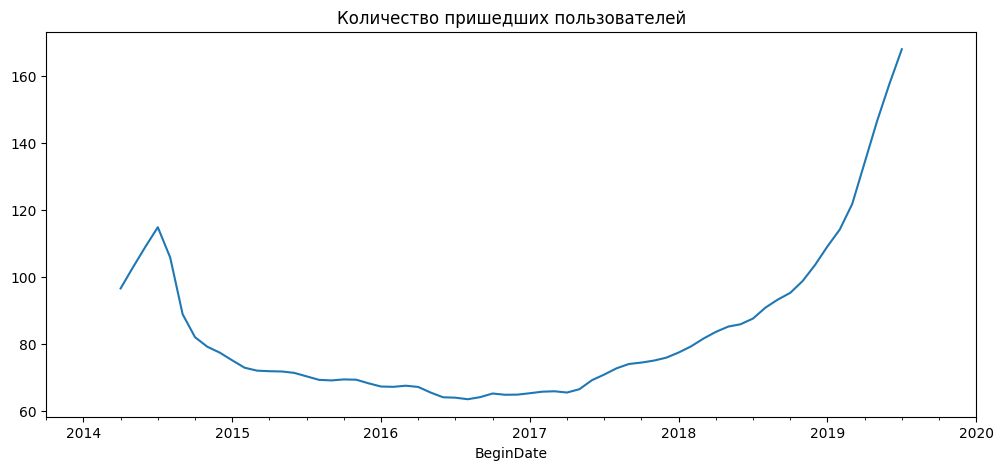

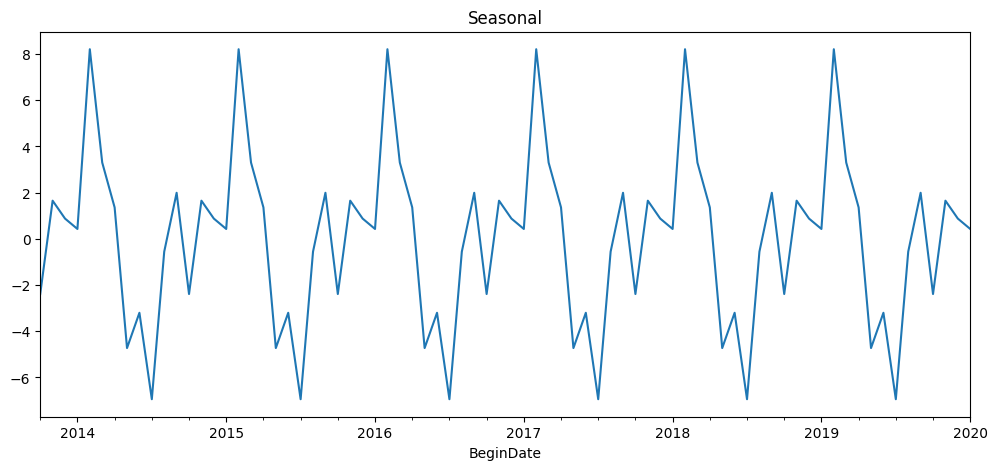

In [34]:
customer_plt_fun('BeginDate', 'Type', 'Количество пришедших пользователей')

- С 2017 года количество клиентов ростет
- есть сезонность прихода клиентов

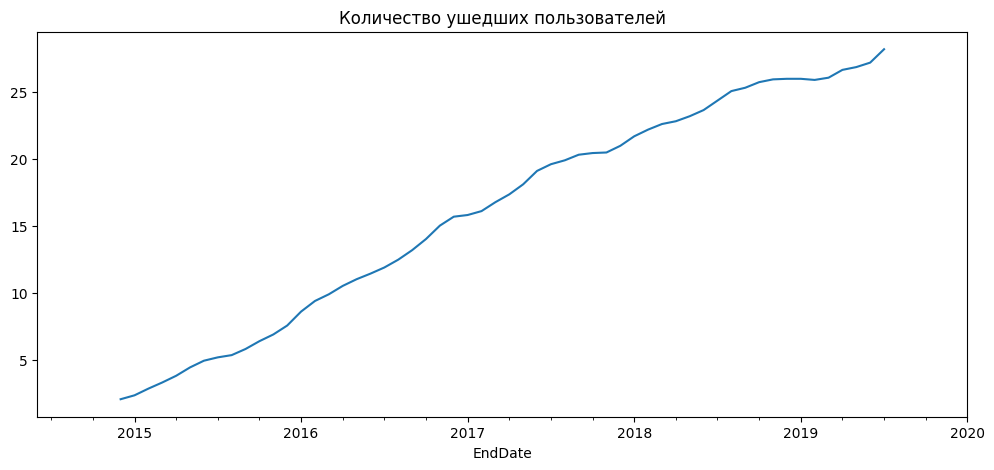

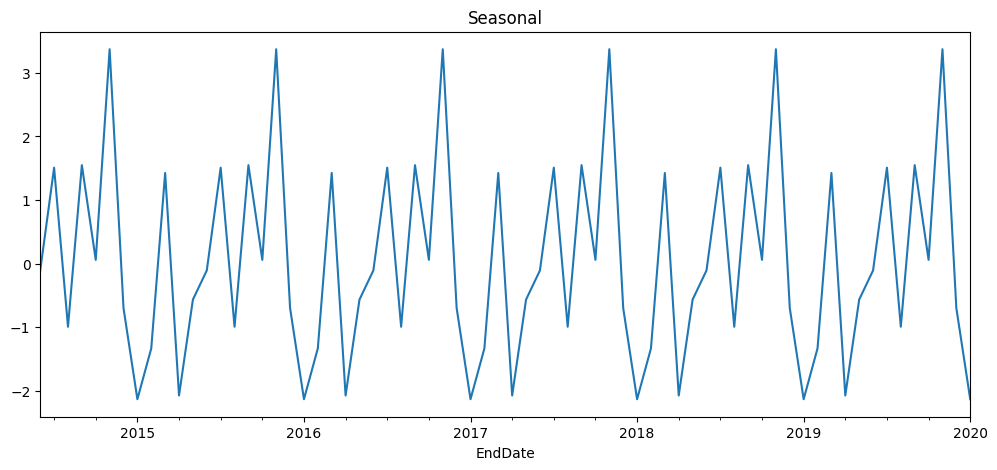

In [35]:
customer_plt_fun('EndDate', 'Type', 'Количество ушедших пользователей')

In [36]:
date_begin_costumer = data.groupby(data['BeginDate'])['Type'].count().resample('1m').sum()
date_end_costumer = data.groupby(data['EndDate'])['Type'].count().resample('1m').sum()
print(date_begin_costumer.head())
print(date_end_costumer.head())

BeginDate
2013-10-31      3
2013-11-30      2
2013-12-31      3
2014-01-31      7
2014-02-28    366
Freq: M, Name: Type, dtype: int64
EndDate
2014-06-30    1
2014-07-31    0
2014-08-31    0
2014-09-30    2
2014-10-31    1
Freq: M, Name: Type, dtype: int64


In [37]:
date_begin_costumer = date_begin_costumer.to_frame (name='begin')
date_end_costumer = date_end_costumer.to_frame (name='end')
date_costumer = pd.concat([date_begin_costumer, date_end_costumer], axis=1)
date_costumer = date_costumer.fillna(0)

In [38]:
date_costumer['result'] = date_costumer['begin'] - date_costumer['end']
date_costumer


begin     end  result
2013-10-31      3     0.0     3.0
2013-11-30      2     0.0     2.0
2013-12-31      3     0.0     3.0
2014-01-31      7     0.0     7.0
2014-02-28    366     0.0   366.0
...           ...     ...     ...
2019-10-31    237    31.0   206.0
2019-11-30    237    30.0   207.0
2019-12-31    220    38.0   182.0
2020-01-31    233    39.0   194.0
2020-02-29     11  5942.0 -5931.0

[77 rows x 3 columns]

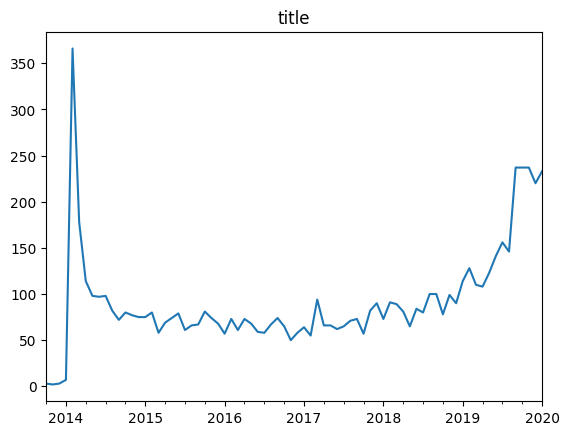

In [39]:
date_costumer = date_costumer.loc[:'20200131']
date_costumer['begin'].plot(ax=plt.gca())
plt.title('title')
plt.show()

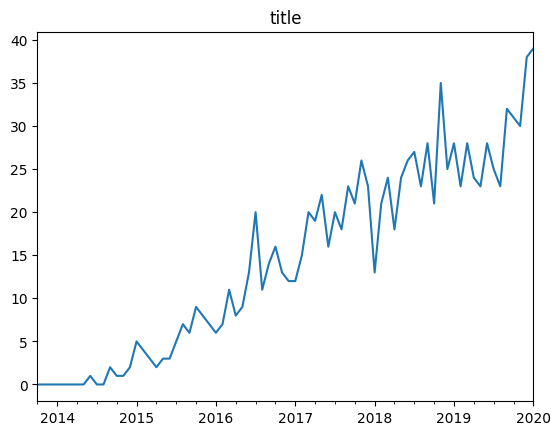

In [40]:
date_costumer['end'].plot(ax=plt.gca())
plt.title('title')
plt.show()

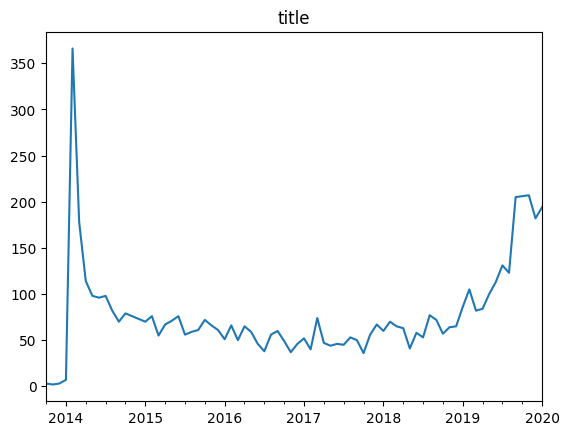

In [41]:
date_costumer['result'].plot(ax=plt.gca())
plt.title('title')
plt.show()

- количество уходящих клиентов всегда росло линейно 
- есть сезонность ухода клиентов 

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   BeginDate            7043 non-null   datetime64[ns]
 1   EndDate              7043 non-null   datetime64[ns]
 2   Type                 7043 non-null   object        
 3   PaperlessBilling     7043 non-null   object        
 4   PaymentMethod        7043 non-null   object        
 5   MonthlyCharges       7043 non-null   float64       
 6   TotalCharges         7043 non-null   float64       
 7   left                 7043 non-null   int64         
 8   MultipleLines        7043 non-null   object        
 9   gender               7043 non-null   object        
 10  SeniorCitizen        7043 non-null   object        
 11  Partner              7043 non-null   object        
 12  Dependents           7043 non-null   object        
 13  InternetService      55

In [43]:
service_columns = ['internet', 'phone', 'onlineSecurity',
                   'onlineBackup', 'device_protection', 'tech_support', 
                   'streming_tv', 'streming_movies']

#функция создает таблицу с количеством пользователей разных услуг
def service_create(data):
    services = [len(data[data.InternetService != "Usen't"]), len(data[data.MultipleLines != "Usen't"]), 
                len(data[data.OnlineSecurity =='Yes']), len(data[data.OnlineBackup =='Yes']), 
                len(data[data.DeviceProtection =='Yes']), len(data[data.TechSupport =='Yes']),
                len(data[data.StreamingTV =='Yes']), len(data[data.StreamingMovies =='Yes'])]
    return services

In [44]:
services = service_create(data)
dframe = pd.DataFrame({'service':service_columns, 'val':services})
display(dframe)

service   val
0           internet  7043
1              phone  6361
2     onlineSecurity  2019
3       onlineBackup  2429
4  device_protection  2422
5       tech_support  2044
6        streming_tv  2707
7    streming_movies  2732

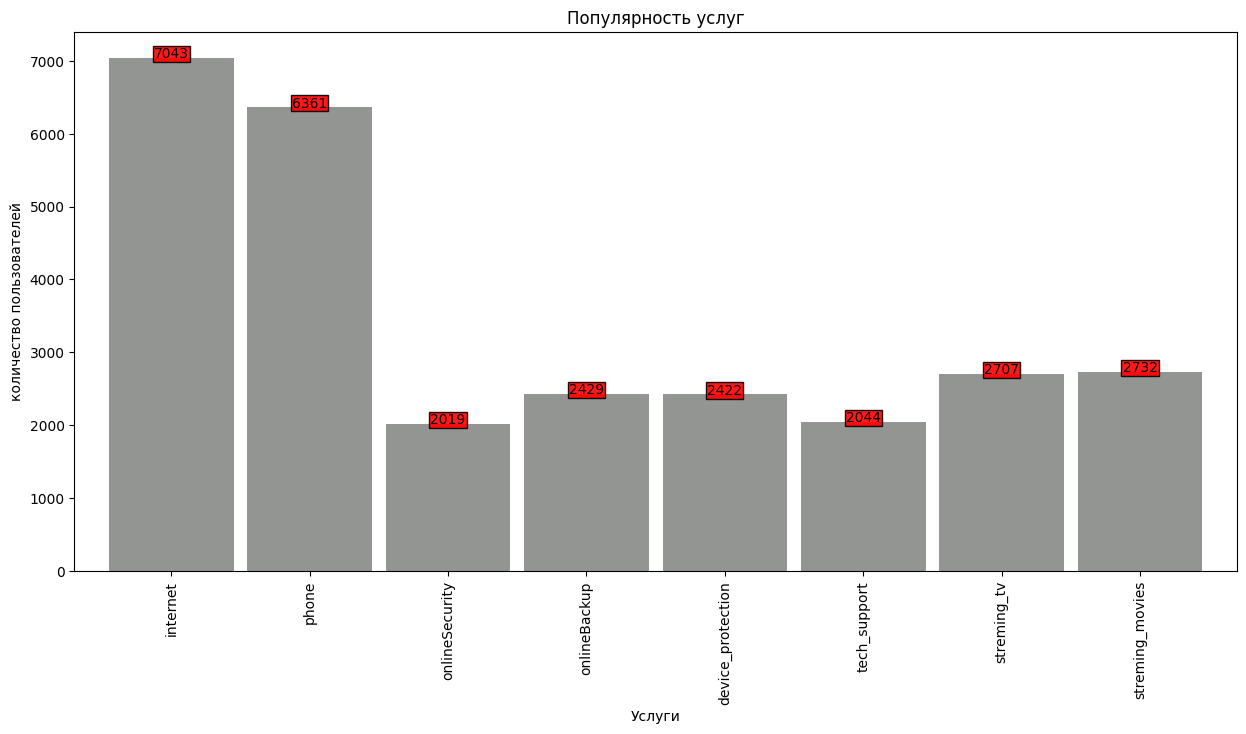

In [45]:
x = dframe['service']
y = dframe['val']

#Функция выводит количество пользователей разных услуг
def services_plot(data):
  
    data.plot(x='service', 
                y='val', 
                kind='bar', 
                legend=False, 
                figsize=(15, 7),
                width=0.9,
                color='#929591' #'#008080'
                )
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center',
                 bbox={'facecolor': 'red', 'alpha': 0.9, 'pad': 0.8})
    plt.xlabel('Услуги')
    plt.ylabel('количество пользователей')
    plt.title('Популярность услуг')
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.show()
services_plot(dframe)

- самые популярные доп услуги - это streming_movies и streming_tv

In [46]:
data_left = data.loc[data['left'] == 1]
data_left.head(10)

BeginDate    EndDate            Type PaperlessBilling  \
customerID                                                          
6388-TABGU 2014-12-01 2017-05-01        One year               No   
3655-SNQYZ 2014-05-01 2016-03-01        Two year               No   
6865-JZNKO 2017-08-01 2018-09-01  Month-to-month              Yes   
3841-NFECX 2014-03-01 2018-11-01        Two year              Yes   
6234-RAAPL 2014-02-01 2018-12-01        Two year               No   
9489-DEDVP 2014-04-01 2019-08-01        Two year              Yes   
1215-FIGMP 2015-02-01 2018-07-01  Month-to-month              Yes   
3887-PBQAO 2016-05-01 2017-09-01        One year              Yes   
6067-NGCEU 2014-09-01 2015-09-01  Month-to-month              Yes   
9848-JQJTX 2014-02-01 2016-07-01        Two year              Yes   

                        PaymentMethod  MonthlyCharges  TotalCharges  left  \
customerID                                                                  
6388-TABGU  Bank transfer (automatic)           56.15       1628.35     1   
3655-SNQYZ    Credit card (automatic)          113.25       2491.50     1   
6865-JZNKO  Bank transfer (automatic)           55.30        726.09     1   
3841-NFECX    Credit card (automatic)           96.35       5395.60     1   
6234-RAAPL  Bank transfer (automatic)           99.90       5794.20     1   
9489-DEDVP    Credit card (automatic)           69.20       4428.80     1   
1215-FIGMP  Bank transfer (automatic)           89.90       3685.90     1   
3887-PBQAO    Credit card (automatic)           25.90        414.40     1   
6067-NGCEU    Credit card (automatic)          111.05       1359.25     1   
9848-JQJTX  Bank transfer (automatic)          100.90       2984.62     1   

           MultipleLines  gender  ... Partner Dependents InternetService  \
customerID                        ...                                      
6388-TABGU            No    Male  ...      No        Yes             DSL   
3655-SNQYZ           Yes  Female  ...     Yes        Yes     Fiber optic   
6865-JZNKO            No  Female  ...      No         No             DSL   
3841-NFECX           Yes  Female  ...     Yes         No     Fiber optic   
6234-RAAPL           Yes  Female  ...     Yes        Yes     Fiber optic   
9489-DEDVP           Yes  Female  ...     Yes        Yes             DSL   
1215-FIGMP           Yes    Male  ...      No         No     Fiber optic   
3887-PBQAO           Yes  Female  ...     Yes        Yes             NaN   
6067-NGCEU           Yes  Female  ...      No         No     Fiber optic   
9848-JQJTX           Yes    Male  ...      No         No     Fiber optic   

           OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
customerID                                                            
6388-TABGU            Yes          Yes               No          No   
3655-SNQYZ            Yes          Yes              Yes         Yes   
6865-JZNKO            Yes          Yes               No          No   
3841-NFECX            Yes          Yes              Yes         Yes   
6234-RAAPL            Yes          Yes               No         Yes   
9489-DEDVP            Yes          Yes               No          No   
1215-FIGMP             No          Yes               No          No   
3887-PBQAO            NaN          NaN              NaN         NaN   
6067-NGCEU            Yes          Yes              Yes          No   
9848-JQJTX             No          Yes              Yes          No   

           StreamingTV StreamingMovies additional_services  
customerID                                                  
6388-TABGU          No              No                   2  
3655-SNQYZ         Yes             Yes                   6  
6865-JZNKO          No              No                   2  
3841-NFECX          No              No                   4  
6234-RAAPL         Yes              No                   4  
9489-DEDVP         Yes              No                   3  
1215

In [47]:
services_left = service_create(data_left)
dframe_left = pd.DataFrame({'service':service_columns, 'val':services_left})
display(dframe_left)

service   val
0           internet  1101
1              phone   998
2     onlineSecurity   415
3       onlineBackup   560
4  device_protection   550
5       tech_support   398
6        streming_tv   584
7    streming_movies   606

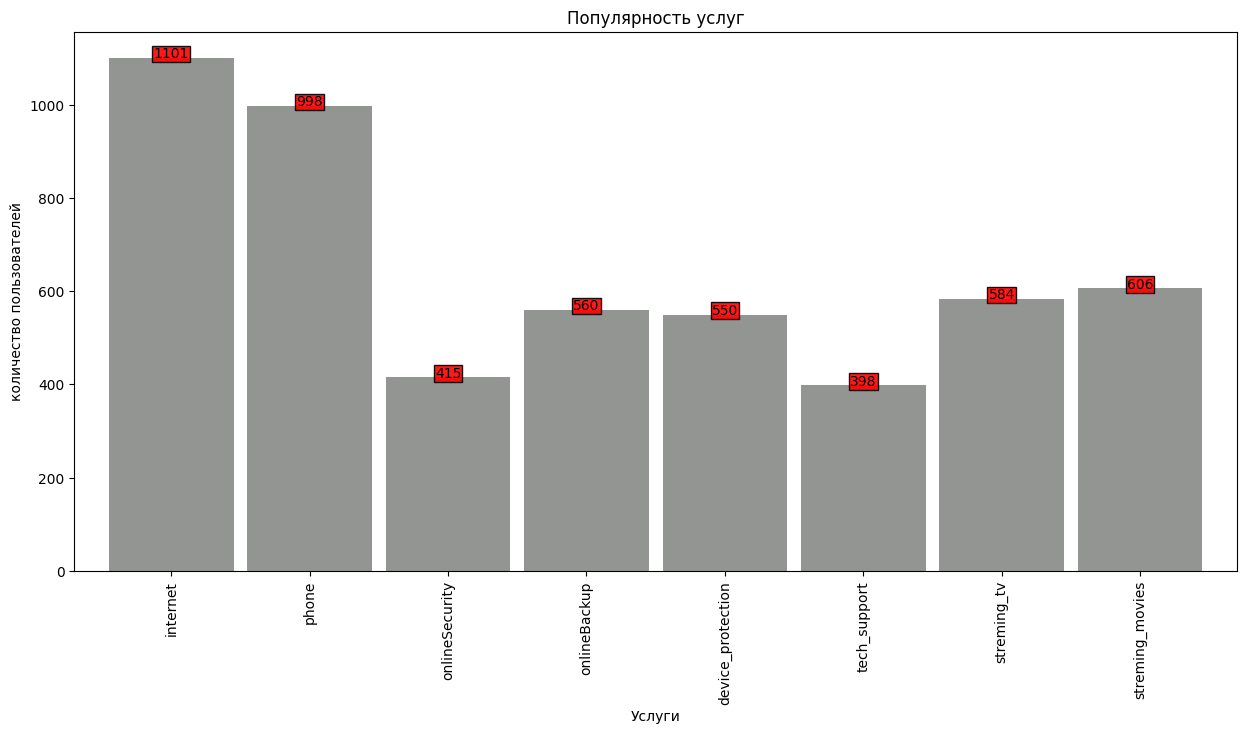

In [48]:
x = dframe_left['service']
y = dframe_left['val']

services_plot(dframe_left)

In [49]:
#Функция выводит графики с относительным количеством ушедших пользователей по каждой колонке 
def print_unique_values(data_left, data):
    n_cols = len(data_left.columns)
    fig, axes = plt.subplots(nrows=n_cols, ncols=3, figsize=(15, n_cols*5), dpi=144)
    
    for i, col in enumerate(data_left.columns):
        
        unique_values = data[col].value_counts()
        unique_values_left = data_left[col].value_counts()
        vals = unique_values_left / unique_values
        labels = unique_values_left.index.tolist()
        
        ax_left = axes[i][0]
        ax_left.pie(unique_values_left, autopct='%1.1f%%', labels=labels, shadow=True, wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"}, rotatelabels=True)
        ax_left.axis("equal")
        ax_left.title.set_text(f"Ушедшие % {col}")

        ax_ratio = axes[i][1]
        ax_ratio.bar(labels, unique_values_left, alpha=0.7, edgecolor="k", lw=1)
        ax_ratio.bar_label (ax_ratio.containers [ 0 ])
        #ax_ratio.set_ylim([0, 2])
        ax_ratio.title.set_text(f"Ушедшие (абсолютное количество){col}")
        
        ax_ratio = axes[i][2]
        ax_ratio.bar(labels, vals, alpha=0.7, edgecolor="k", lw=1)
        ax_ratio.bar_label (ax_ratio.containers [ 0 ])
        ax_ratio.set_ylim([0, 2])
        ax_ratio.title.set_text(f"Ушедшие из пользователей категории")
        

    plt.tight_layout()
    plt.show()

Выведем графики ушедших пользователей по колонкам 

Слева направо :
1) процентное количество ушедших по категориям
2) абсолютное количество ушедших в категории
3) относительно количество ушедших от общего количества пользователей в этой категории

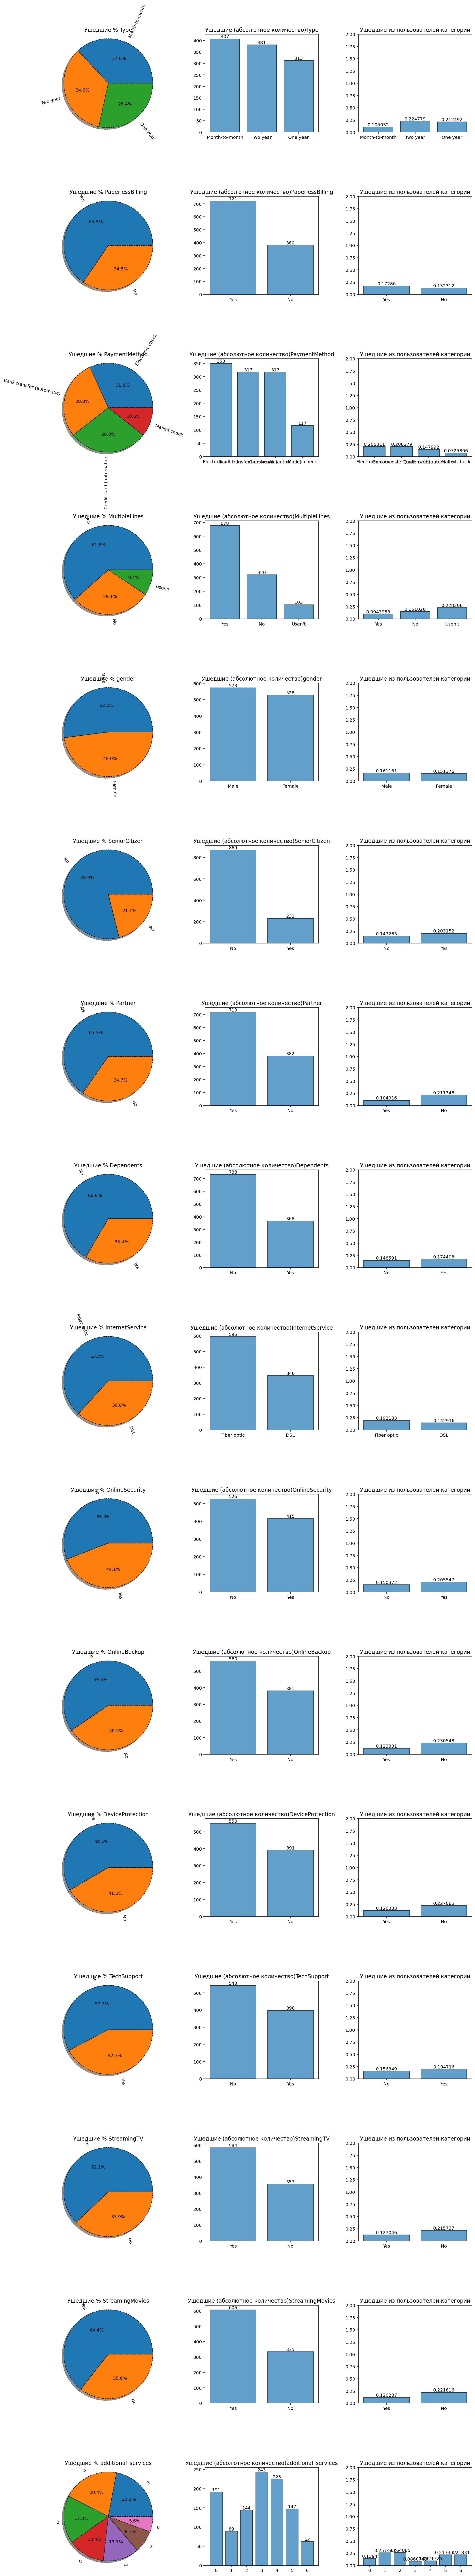

In [50]:
data_left = data_left.drop(['BeginDate', 'EndDate', 'MonthlyCharges', 'TotalCharges', 'left'], axis=1)
print_unique_values(data_left, data)

In [51]:
data['contract_duration'] = (data['EndDate'] - data['BeginDate']).dt.days

In [52]:
data.head()

BeginDate    EndDate            Type PaperlessBilling  \
customerID                                                          
7590-VHVEG 2020-01-01 2020-02-01  Month-to-month              Yes   
5575-GNVDE 2017-04-01 2020-02-01        One year               No   
3668-QPYBK 2019-10-01 2020-02-01  Month-to-month              Yes   
7795-CFOCW 2016-05-01 2020-02-01        One year               No   
9237-HQITU 2019-09-01 2020-02-01  Month-to-month              Yes   

                        PaymentMethod  MonthlyCharges  TotalCharges  left  \
customerID                                                                  
7590-VHVEG           Electronic check           29.85         31.04     0   
5575-GNVDE               Mailed check           56.95       2071.84     0   
3668-QPYBK               Mailed check           53.85        226.17     0   
7795-CFOCW  Bank transfer (automatic)           42.30       1960.60     0   
9237-HQITU           Electronic check           70.70        353.50     0   

           MultipleLines  gender  ... Dependents InternetService  \
customerID                        ...                              
7590-VHVEG        Usen't  Female  ...         No             DSL   
5575-GNVDE            No    Male  ...         No             DSL   
3668-QPYBK            No    Male  ...         No             DSL   
7795-CFOCW        Usen't    Male  ...         No             DSL   
9237-HQITU            No  Female  ...         No     Fiber optic   

           OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
customerID                                                            
7590-VHVEG             No          Yes               No          No   
5575-GNVDE            Yes           No              Yes          No   
3668-QPYBK            Yes          Yes               No          No   
7795-CFOCW            Yes           No              Yes         Yes   
9237-HQITU             No           No               No          No   

           StreamingTV StreamingMovies additional_services contract_duration  
customerID                                                                    
7590-VHVEG          No              No                   1                31  
5575-GNVDE          No              No                   2              1036  
3668-QPYBK          No              No                   2               123  
7795-CFOCW          No              No                   3              1371  
9237-HQITU          No              No                   0               153  

[5 rows x 22 columns]

In [53]:
data = data.drop(['BeginDate', 'EndDate', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender'], axis=1)
data.reset_index(drop=True, inplace=True)

In [54]:
features = data.drop('left', axis = 1)
target = data['left']
features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.25, 
                                                                              random_state=80523
                                                                             )

In [55]:
features_train_enc = features_train.copy()
features_valid_enc = features_valid.copy()
columns_enc = features.select_dtypes('object').columns.tolist()
num_features = features_train.select_dtypes(exclude='object').columns.to_list()

ohe_enc = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
ohe_enc.fit(features_train_enc[columns_enc])

features_train_enc[ohe_enc.get_feature_names_out()] = ohe_enc.transform(features_train_enc[columns_enc])
features_train_enc = features_train_enc.drop(columns_enc, axis=1)
features_train_enc_2 = features_train_enc.copy()
scaler = StandardScaler()
features_train_enc[num_features] = scaler.fit_transform(features_train_enc[num_features])

features_train_enc.head()

MonthlyCharges  TotalCharges  additional_services  contract_duration  \
1214        0.708300     -0.023740            -0.561989          -0.323653   
827        -1.299800     -0.824235            -1.105059          -0.680887   
6266        0.636879      0.346607            -0.018918           0.210734   
1010       -0.482608     -0.921563            -0.561989          -1.171352   
4397        1.304584      2.592863             1.610294           1.901740   

      Type_One year  Type_Two year  PaperlessBilling_Yes  \
1214            0.0            0.0                   1.0   
827             0.0            0.0                   0.0   
6266            0.0            0.0                   1.0   
1010            0.0            0.0                   1.0   
4397            0.0            1.0                   1.0   

      PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
1214                                    0.0                             0.0   
827                                     0.0                             0.0   
6266                                    1.0                             0.0   
1010                                    0.0                             0.0   
4397                                    0.0                             0.0   

      PaymentMethod_Mailed check  MultipleLines_Usen't  MultipleLines_Yes  \
1214                         0.0                   0.0                1.0   
827                          1.0                   0.0                1.0   
6266                         0.0                   0.0                1.0   
1010                         1.0                   0.0                0.0   
4397                         0.0                   0.0                1.0   

      SeniorCitizen_Yes  Partner_Yes  Dependents_Yes  \
1214                0.0          0.0             0.0   
827                 0.0          1.0             1.0   
6266                1.0          0.0             0.0   
1010                0.0          0.0             0.0   
4397                0.0          1.0             0.0   

      InternetService_Fiber optic  InternetService_nan  
1214                          1.0                  0.0  
827                           0.0                  1.0  
6266                          1.0                  0.0  
1010                          0.0                  0.0  
4397                          1.0                  0.0

In [56]:
features_valid_enc[ohe_enc.get_feature_names_out()] = ohe_enc.transform(features_valid_enc[columns_enc])

features_valid_enc = features_valid_enc.drop(columns_enc, axis=1)
features_valid_enc_2 = features_valid_enc.copy()
features_valid_enc[num_features] = scaler.transform(features_valid_enc[num_features])

features_valid_enc.head()

MonthlyCharges  TotalCharges  additional_services  contract_duration  \
1340       -0.286615     -0.965894             1.610294          -1.306047   
138        -1.497454     -0.446576            -1.105059           1.237050   
4357       -1.469218     -0.835196            -1.105059          -0.636965   
1776       -1.318071     -0.130004            -1.105059           1.901740   
3509       -0.657009     -0.970074            -1.105059          -1.260661   

      Type_One year  Type_Two year  PaperlessBilling_Yes  \
1340            0.0            1.0                   0.0   
138             0.0            1.0                   1.0   
4357            0.0            0.0                   0.0   
1776            0.0            1.0                   1.0   
3509            0.0            0.0                   1.0   

      PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
1340                                    1.0                             0.0   
138                                     0.0                             0.0   
4357                                    1.0                             0.0   
1776                                    0.0                             0.0   
3509                                    0.0                             0.0   

      PaymentMethod_Mailed check  MultipleLines_Usen't  MultipleLines_Yes  \
1340                         0.0                   1.0                0.0   
138                          1.0                   0.0                0.0   
4357                         0.0                   0.0                0.0   
1776                         0.0                   0.0                1.0   
3509                         1.0                   0.0                0.0   

      SeniorCitizen_Yes  Partner_Yes  Dependents_Yes  \
1340                0.0          1.0             1.0   
138                 0.0          0.0             1.0   
4357                0.0          1.0             0.0   
1776                1.0          1.0             0.0   
3509                0.0          0.0             0.0   

      InternetService_Fiber optic  InternetService_nan  
1340                          0.0                  0.0  
138                           0.0                  1.0  
4357                          0.0                  1.0  
1776                          0.0                  1.0  
3509                          0.0                  0.0

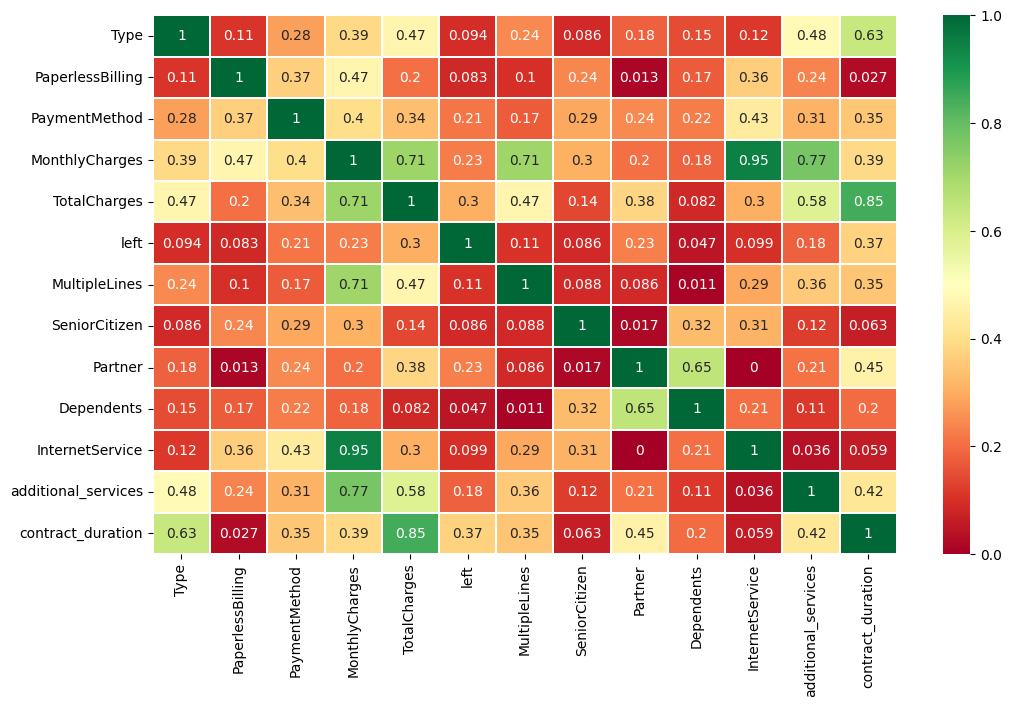

In [57]:
fig, ax = plt.subplots(figsize = (12, 7))

sns.heatmap(data.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'contract_duration']), cmap ='RdYlGn', linewidths = 0.30, annot = True)
plt.show()

- Есть корреляция между длительностью контракта и общей суммой платежей 
- Есть корреляция между ежемесячной платой и доп услугами 
- Есть корреляция между подключением интернета и многоканальным телефоном 
- Также есть небольшая корреляция между месечными платежами и общей суммой платежей, длительностью контракта и типом контракта, типом контракта и доп услугами
- Целевой признак коррелирует с данными слабо , возможно есть связь с длительностью контракта 
- Признак gender почти не коррелирует с другими признаками, его можно удалить

In [58]:
features_train = features_train_enc.drop('TotalCharges', axis=1)
features_valid = features_valid_enc.drop('TotalCharges', axis=1)

features_train_2 = features_train_enc_2.drop('TotalCharges', axis=1)
features_valid_2 = features_valid_enc_2.drop('TotalCharges', axis=1)

In [59]:
features_train_2

MonthlyCharges  additional_services  contract_duration  Type_One year  \
1214           86.00                    1                671            0.0   
827            25.55                    0                427            0.0   
6266           83.85                    2               1036            0.0   
1010           50.15                    1                 92            0.0   
4397          103.95                    5               2191            0.0   
...              ...                  ...                ...            ...   
5658           93.00                    2                730            0.0   
6174           29.65                    1                215            0.0   
6332          105.25                    5               2071            0.0   
281            51.20                    1                306            0.0   
2409           60.00                    5                853            1.0   

      Type_Two year  PaperlessBilling_Yes  \
1214            0.0                   1.0   
827             0.0                   0.0   
6266            0.0                   1.0   
1010            0.0                   1.0   
4397            1.0                   1.0   
...             ...                   ...   
5658            0.0                   1.0   
6174            0.0                   1.0   
6332            1.0                   1.0   
281             0.0                   0.0   
2409            0.0                   1.0   

      PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
1214                                    0.0                             0.0   
827                                     0.0                             0.0   
6266                                    1.0                             0.0   
1010                                    0.0                             0.0   
4397                                    0.0                             0.0   
...                                     ...                             ...   
5658                                    0.0                             1.0   
6174                                    0.0                             1.0   
6332                                    0.0                             0.0   
281                                     0.0                             1.0   
2409                                    1.0                             0.0   

      PaymentMethod_Mailed check  MultipleLines_Usen't  MultipleLines_Yes  \
1214                         0.0                   0.0                1.0   
827                          1.0                   0.0                1.0   
6266                         0.0                   0.0                1.0   
1010                         1.0                   0.0                0.0   
4397                         0.0                   0.0                1.0   
...                          ...                   ...                ...   
5658                         0.0                   0.0                1.0   
6174                         0.0                   1.0                0.0   
6332                         0.0                   0.0                0.0   
281                          0.0                   0.0                0.0   
2409                         0.0                   1.0                0.0   

      SeniorCitizen_Yes  Partner_Yes  Dependents_Yes  \
1214                0.0          0.0             0.0   
827                 0.0          1.0             1.0   
6266                1.0          0.0             0.0   
1010                0.0          0.0             0.0   
4397                0.0          1.0             0.0   
...                 ...          ...             ...   
5658                0.0          1.0             0.0   
6174                0.0          0.0             0.0   
6332                0.0          1.0             1.0   
281                 0.0          0.0             0.0   
2409                0.0   

In [60]:
features_train

MonthlyCharges  additional_services  contract_duration  Type_One year  \
1214        0.708300            -0.561989          -0.323653            0.0   
827        -1.299800            -1.105059          -0.680887            0.0   
6266        0.636879            -0.018918           0.210734            0.0   
1010       -0.482608            -0.561989          -1.171352            0.0   
4397        1.304584             1.610294           1.901740            0.0   
...              ...                  ...                ...            ...   
5658        0.940834            -0.018918          -0.237273            0.0   
6174       -1.163601            -0.561989          -0.991271            0.0   
6332        1.347769             1.610294           1.726051            0.0   
281        -0.447728            -0.561989          -0.858040            0.0   
2409       -0.155399             1.610294          -0.057191            1.0   

      Type_Two year  PaperlessBilling_Yes  \
1214            0.0                   1.0   
827             0.0                   0.0   
6266            0.0                   1.0   
1010            0.0                   1.0   
4397            1.0                   1.0   
...             ...                   ...   
5658            0.0                   1.0   
6174            0.0                   1.0   
6332            1.0                   1.0   
281             0.0                   0.0   
2409            0.0                   1.0   

      PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
1214                                    0.0                             0.0   
827                                     0.0                             0.0   
6266                                    1.0                             0.0   
1010                                    0.0                             0.0   
4397                                    0.0                             0.0   
...                                     ...                             ...   
5658                                    0.0                             1.0   
6174                                    0.0                             1.0   
6332                                    0.0                             0.0   
281                                     0.0                             1.0   
2409                                    1.0                             0.0   

      PaymentMethod_Mailed check  MultipleLines_Usen't  MultipleLines_Yes  \
1214                         0.0                   0.0                1.0   
827                          1.0                   0.0                1.0   
6266                         0.0                   0.0                1.0   
1010                         1.0                   0.0                0.0   
4397                         0.0                   0.0                1.0   
...                          ...                   ...                ...   
5658                         0.0                   0.0                1.0   
6174                         0.0                   1.0                0.0   
6332                         0.0                   0.0                0.0   
281                          0.0                   0.0                0.0   
2409                         0.0                   1.0                0.0   

      SeniorCitizen_Yes  Partner_Yes  Dependents_Yes  \
1214                0.0          0.0             0.0   
827                 0.0          1.0             1.0   
6266                1.0          0.0             0.0   
1010                0.0          0.0             0.0   
4397                0.0          1.0             0.0   
...                 ...          ...             ...   
5658                0.0          1.0             0.0   
6174                0.0          0.0             0.0   
6332                0.0          1.0             1.0   
281                 0.0          0.0             0.0   
2409                0.0   

### Обучение моделей

In [61]:
cv = 10

In [62]:
%%time

# Без стандартизации

param = {"C":np.logspace(0.1 , 10, 7)}
grid_lr_2 = GridSearchCV(LogisticRegression(class_weight='balanced', random_state = 80523),
                         param,
                         cv=cv,
                         scoring='roc_auc',
                         refit='roc_auc',
                         n_jobs=-1,
                         verbose=10
                        )

grid_lr_2.fit(features_train_2, target_train)
best_model_lr_2 = grid_lr_2.best_estimator_
best_score_lr_2 = grid_lr_2.best_score_
best_time_lr_2 = grid_lr_2.refit_time_
print(grid_lr_2.best_score_)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
0.7529960838549831
CPU times: total: 406 ms
Wall time: 1.3 s


In [63]:
%%time

# С стандартизацией

param = {"C":np.logspace(0.1 , 10, 7)}
grid_lr = GridSearchCV(LogisticRegression(class_weight='balanced', random_state = 80523),
                       param,
                       cv=cv,
                       scoring='roc_auc',
                       refit='roc_auc',
                       n_jobs=-1,
                       verbose=10
                      )

grid_lr.fit(features_train, target_train)
best_model_lr = grid_lr.best_estimator_
best_score_lr = grid_lr.best_score_
best_time_lr = grid_lr.refit_time_
print(grid_lr.best_score_)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
0.7518848562626916
CPU times: total: 188 ms
Wall time: 481 ms


In [64]:
start = time.time()
predictions = best_model_lr.predict(features_train)
end = time.time()
pred_lr_time = end-start 

In [65]:
%%time

parametrs = {'max_depth': np.arange(2, 15)}
grid_rfc = GridSearchCV(RandomForestClassifier(random_state = 80523, 
                                               class_weight='balanced'
                                              ), 
                        parametrs, 
                        cv=cv,
                        scoring='roc_auc',
                        refit='roc_auc',
                        n_jobs=-1, 
                        verbose=10
                       )
grid_rfc.fit(features_train, target_train)
grid_rfc.best_params_

best_params_rfc = grid_rfc.best_params_
best_score_rfc = grid_rfc.best_score_
best_model_rfc = grid_rfc.best_estimator_
best_time_rfc = grid_rfc.refit_time_
print(best_params_rfc)
print('best score: ', best_score_rfc)
print('best time: ', best_time_rfc)

Fitting 10 folds for each of 13 candidates, totalling 130 fits
{'max_depth': 6}
best score:  0.8272809771602608
best time:  0.3188209533691406
CPU times: total: 953 ms
Wall time: 7.55 s


In [66]:
start = time.time()
predictions = best_model_rfc.predict(features_train)
end = time.time()
pred_rfc_time = end-start 

In [67]:
%%time

parameters = {'max_depth': np.arange(15, 16), #(1,25)
              'n_estimators': np.arange(200, 201) #(1, 201, 10)
             }

grid_lgbmc = GridSearchCV(LGBMClassifier(random_state = 80523,
                                         class_weight='balanced'
                                        ), 
                          parameters,
                          cv=cv,
                          scoring='roc_auc',
                          refit='roc_auc',
                          n_jobs=-1, 
                          verbose=10
                         )


grid_lgbmc.fit(features_train, target_train)

best_params_lgbmc = grid_lgbmc.best_params_
best_score_lgbmc = grid_lgbmc.best_score_
best_model_lgbmc = grid_lgbmc.best_estimator_
best_time_lgbmc = grid_lgbmc.refit_time_
print(best_params_lgbmc)
print('best score: ', best_score_lgbmc)
print('best time: ', best_time_lgbmc)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
{'max_depth': 15, 'n_estimators': 200}
best score:  0.8926157255556697
best time:  0.16528105735778809
CPU times: total: 1.67 s
Wall time: 2.3 s


In [68]:
start = time.time()
predictions = best_model_lgbmc.predict(features_train)
end = time.time()
pred_lgbmc_time = end-start 

In [69]:
%%time

cbc = CatBoostClassifier(random_state = 80523,
                         learning_rate= 0.1778279410038923,
                         silent=True,
                         auto_class_weights='Balanced'
                        )

params = {#'learning_rate': np.logspace(-3, 0, 5),
          'iterations': [2000], #[100, 200, 500, 1000, 2000]
          'depth': [d for d in range(2, 3)], #(1, 15)
         }

grid_cbc = GridSearchCV(cbc,
                        params,
                        cv=cv,
                        scoring='roc_auc', 
                        refit='roc_auc',
                        n_jobs=-1, 
                        verbose=10
                       )

grid_cbc.fit(features_train, target_train)
grid_cbc.best_params_
best_params_cbc = grid_cbc.best_params_
best_score_cbc = grid_cbc.best_score_
best_model_cbc = grid_cbc.best_estimator_
best_time_cbc = grid_cbc.refit_time_
print(best_params_cbc)
print(best_score_cbc)
print(best_time_cbc)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
{'depth': 2, 'iterations': 2000}
0.929855718589032
4.0382091999053955
CPU times: total: 4.41 s
Wall time: 12.9 s


In [70]:
start = time.time()
predictions = best_model_cbc.predict(features_train)
end = time.time()
pred_cbc_time = end-start 

### Анализ моделей

In [71]:
#Создание таблицы и графика с результатами обучения модели 
models = []
models.append([best_time_lr, pred_lr_time, best_score_lr])
models.append([best_time_lgbmc, pred_lgbmc_time, best_score_lgbmc])
models.append([best_time_rfc, pred_rfc_time, best_score_rfc])
models.append([best_time_cbc, pred_cbc_time, best_score_cbc])

In [72]:
result_table = pd.DataFrame(data=models, 
                            index=['LogisticRegression', 'LightGBM','RandomForest', 'CatBoost'], 
                            columns=['trainig_time', 'predict_time', 'ROC-AUC']
                           )
result_table

trainig_time  predict_time   ROC-AUC
LogisticRegression      0.014732      0.001991  0.751885
LightGBM                0.165281      0.015434  0.892616
RandomForest            0.318821      0.051047  0.827281
CatBoost                4.038209      0.008469  0.929856

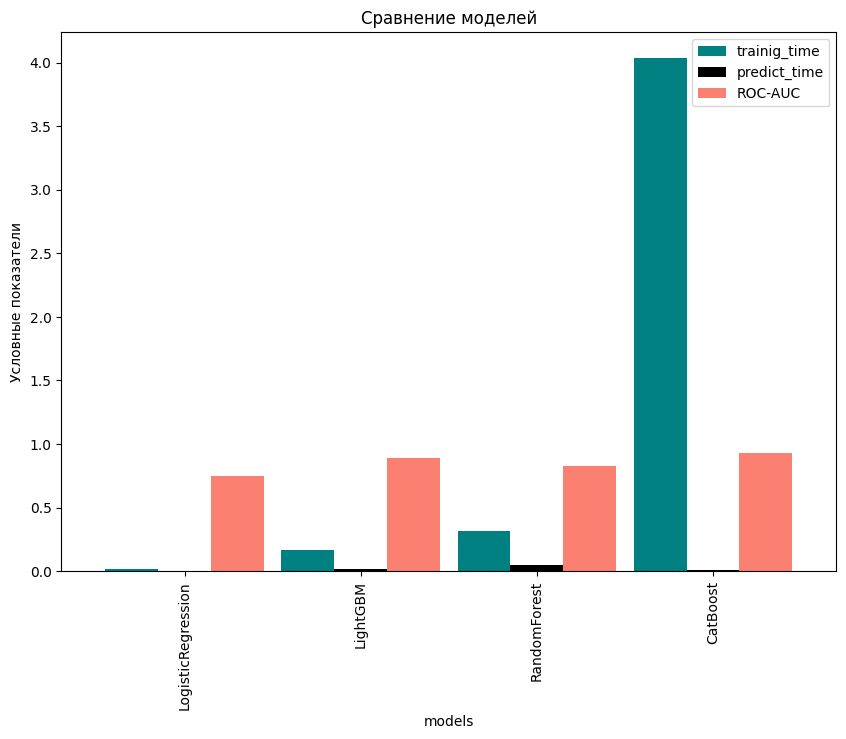

In [73]:
result_table.plot(kind='bar', 
                  legend=False, 
                  figsize=(10, 7), 
                  width=0.9, 
                  color=('#008080', '#000000', '#FA8072')
                 )
plt.xlabel('models')
plt.ylabel('Условные показатели')
plt.legend(list(result_table))
plt.title('Сравнение моделей')
plt.show()

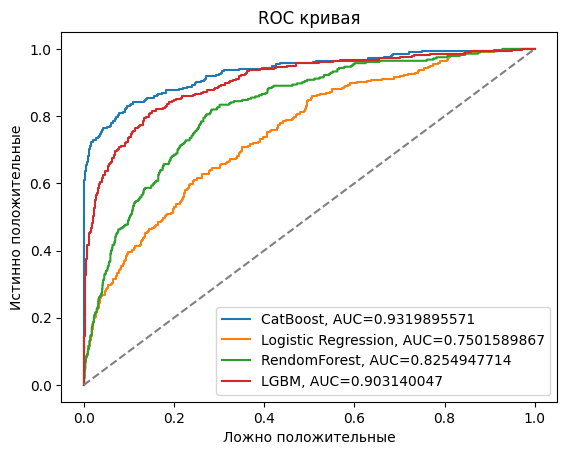

In [74]:
#создание AUC-ROC кривых для всех моделий на одном графике
plt.figure(0).clf ()

y_pred = grid_cbc.best_estimator_.predict_proba(features_valid)[:, 1]
fpr, tpr, _ = metrics.roc_curve(target_valid, y_pred)
auc = round(metrics.roc_auc_score(target_valid, y_pred), 10)
plt.plot(fpr,tpr,label="CatBoost, AUC="+str(auc))

y_pred = grid_lr.best_estimator_.predict_proba(features_valid)[:, 1]
fpr, tpr, _ = metrics.roc_curve(target_valid, y_pred)
auc = round(metrics.roc_auc_score(target_valid, y_pred), 10)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))


y_pred = grid_rfc.best_estimator_.predict_proba(features_valid)[:, 1]
fpr, tpr, _ = metrics.roc_curve(target_valid, y_pred)
auc = round(metrics.roc_auc_score(target_valid, y_pred), 10)
plt.plot(fpr,tpr,label="RendomForest, AUC="+str(auc))

y_pred = grid_lgbmc.best_estimator_.predict_proba(features_valid)[:, 1]
fpr, tpr, _ = metrics.roc_curve(target_valid, y_pred)
auc = round(metrics.roc_auc_score(target_valid, y_pred), 10)
plt.plot(fpr,tpr,label="LGBM, AUC="+str(auc))

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel('Ложно положительные')
plt.ylabel('Истинно положительные')
plt.title('ROC кривая')

plt.legend() 
plt.show()

### вывод:
- Обучил 4 модели LogisticRegression, RendomForest, LGBM, CatBoost
- Проанализировал оезультаты моделей 
- По результатам тестирования - лучшая модель CatBoost. Выберем ее для дальнейшего тестирования

### проверка лучшей модели

In [75]:
best_model = best_model_cbc
best_train_time = best_time_cbc

In [76]:
start = time.time()
predictions = best_model.predict(features_valid)
end = time.time()

best_pred_time = end-start

In [77]:
best_proba = best_model.predict_proba(features_valid)[:, 1]

In [78]:
cbc_auc = metrics.roc_auc_score(target_valid, best_proba)
cbc_auc

0.9319895570845906

In [79]:
cbc_acu = metrics.accuracy_score(target_valid, predictions)
cbc_acu

0.8972174900624645

In [80]:
start = time.time()
dummy_cf = DummyClassifier(strategy="most_frequent")
dummy_cf.fit(features_train, target_train)
end = time.time()
dummy_train_time = end-start

In [81]:
start = time.time()
dummy_predict = dummy_cf.predict(features_valid)
end = time.time()
dummy_predict_time = end-start

In [82]:
dummy_proba = dummy_cf.predict_proba(features_valid)[:, 1]

In [83]:
dummy_auc = metrics.roc_auc_score(target_valid, dummy_proba)
dummy_auc

0.5

In [84]:
dummy_acu = metrics.accuracy_score(target_valid, dummy_predict)
dummy_acu

0.8392958546280522

<div class="alert alert-success">
<b>Комментарий тимлида 3:</b> Можно не удалять, просто учесть на будущее :)

In [85]:
models_final = []
models_final.append([best_train_time , best_pred_time, cbc_auc, cbc_acu])
models_final.append([dummy_train_time , dummy_predict_time, dummy_auc, dummy_acu])

In [86]:
table_final = pd.DataFrame(data=models_final, 
                            index=['best_model','dummy_model'], 
                            columns=['trainig_time', 'predict_time', 'AUC-ROC', 'accuracy']
                           )
table_final

trainig_time  predict_time  AUC-ROC  accuracy
best_model       4.038209      0.005524  0.93199  0.897217
dummy_model      0.001055      0.000000  0.50000  0.839296

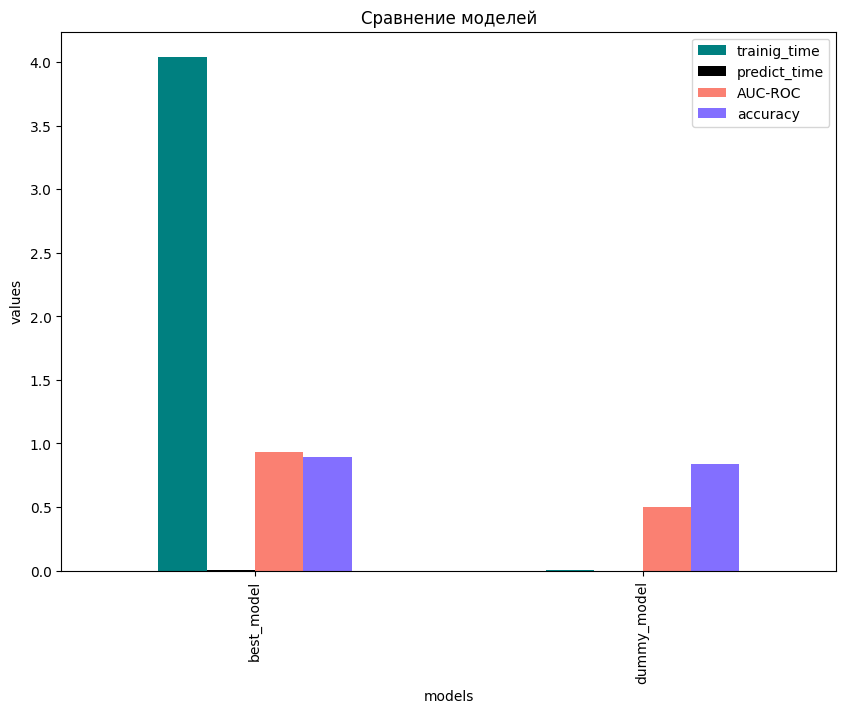

In [87]:
table_final.plot(kind='bar', legend=False, figsize=(10, 7), color=('#008080', '#000000', '#FA8072', '#836FFF'))
plt.xlabel('models')
plt.ylabel('values')
plt.legend(list(table_final))
plt.title('Сравнение моделей')
plt.show()

In [88]:
important_features = best_model.get_feature_importance(Pool(features_train, target_train), prettified = True)

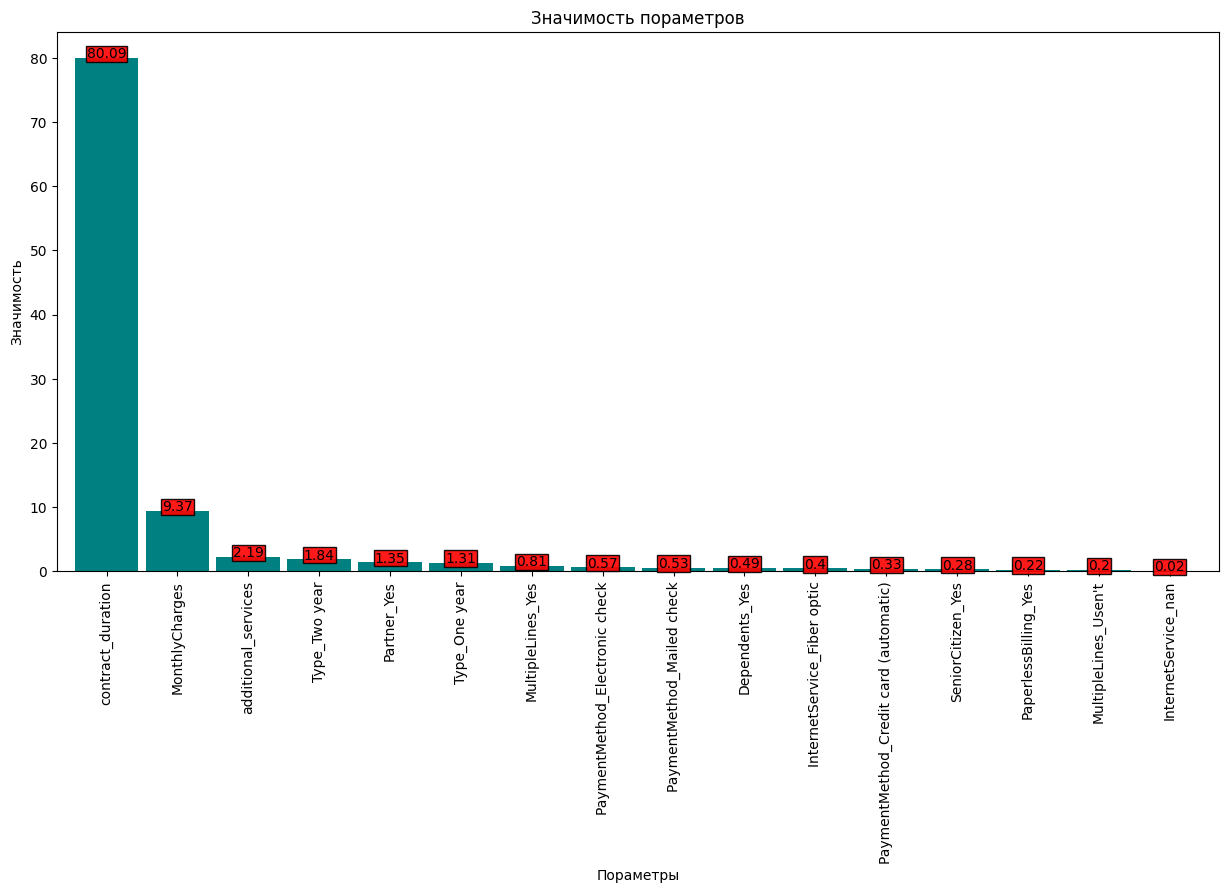

In [89]:
# Создание графика значимости параметров
x = important_features['Feature Id']
y = round(important_features['Importances'], 2)
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center',
                 bbox={'facecolor': 'red', 'alpha': 0.9, 'pad': 0.8})
 
if __name__ == '__main__':
   
   important_features.plot(x='Feature Id', 
                           y='Importances', 
                           kind='bar', 
                           legend=False, 
                           figsize=(15, 7),
                           width=0.9,
                           color='#008080'
                          )
   addlabels(x,y)
   plt.xlabel('Пораметры')
   plt.ylabel('Значимость')
   plt.title('Значимость пораметров')
   plt.tick_params(axis='both', which='major', labelsize=10)
   plt.show()

- Все параметры ниже 1 малозначимы, ими можно пренебречь 

In [90]:
important_columns = important_features.loc[important_features['Importances'] >= 0.5]
important_columns = list(important_columns['Feature Id'])

new_features_train = features_train[important_columns]
new_features_valid = features_valid[important_columns]

In [91]:
%%time

cbc = CatBoostClassifier(random_state = 80523,
                         silent=True,
                         learning_rate= 0.1778279410038923,
                         auto_class_weights='Balanced'
                        )

params = {#'learning_rate': np.logspace(-3, 0, 5),
          'iterations': [2000], #[100, 200, 500, 1000, 2000]
          'depth': [d for d in range(2, 3)], #(1, 15)
         }

new_grid_cbc = GridSearchCV(cbc,
                        params,
                        cv=cv,
                        scoring='roc_auc', 
                        n_jobs=-1, 
                        verbose=10
                       )

new_grid_cbc.fit(new_features_train, target_train)
new_grid_cbc.best_params_
new_best_params_cbc = new_grid_cbc.best_params_
new_best_score_cbc = new_grid_cbc.best_score_
new_best_model_cbc = new_grid_cbc.best_estimator_
new_best_time_cbc = new_grid_cbc.refit_time_
print(new_best_params_cbc)
print(new_best_score_cbc)
print(new_best_time_cbc)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
{'depth': 2, 'iterations': 2000}
0.9315556394168703
3.8812146186828613
CPU times: total: 3.92 s
Wall time: 11.8 s


In [92]:
new_best_model = new_best_model_cbc

In [93]:
new_predictions = new_grid_cbc.predict(new_features_valid)

In [94]:
new_proba = new_best_model.predict_proba(new_features_valid)[:, 1]

In [95]:
new_cbc_auc = metrics.roc_auc_score(target_valid, new_proba)
new_cbc_auc

0.9311671296805443

In [96]:
cbc_acu = metrics.accuracy_score(target_valid, new_predictions)
cbc_acu

0.8949460533787621

- предсказание немного ухудшились 

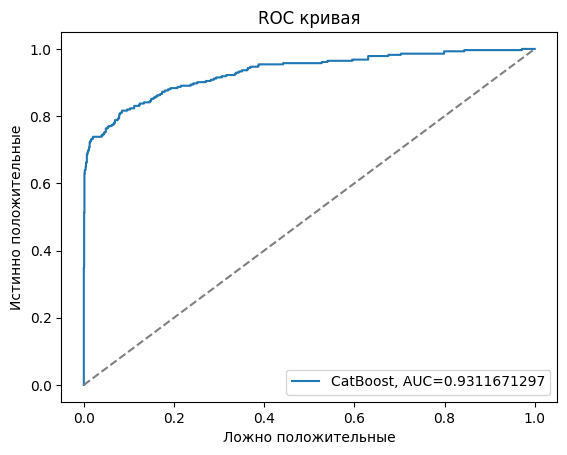

In [97]:
plt.figure(0).clf ()

y_pred = new_best_model.predict_proba(new_features_valid)[:, 1]
fpr, tpr, _ = metrics.roc_curve(target_valid, y_pred)
auc = round(metrics.roc_auc_score(target_valid, y_pred), 10)
plt.plot(fpr,tpr,label="CatBoost, AUC="+str(auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel('Ложно положительные')
plt.ylabel('Истинно положительные')
plt.title('ROC кривая')

plt.legend() 
plt.show()

      0    1
0  1345  133
1    52  231


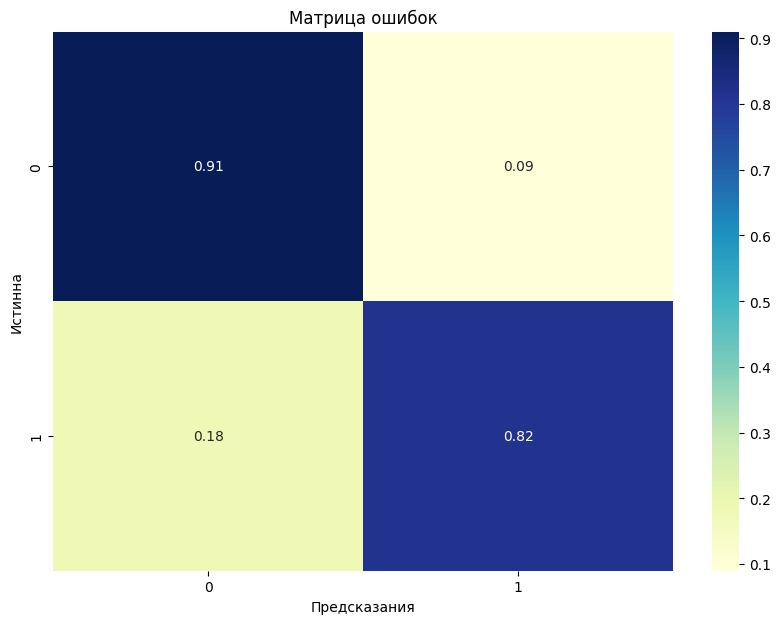

In [98]:
cm = confusion_matrix(target_valid, new_predictions)

df_cm = pd.DataFrame(cm, index=[i for i in range(len(cm))], columns=[i for i in range(len(cm[0]))])

print(df_cm)

corr_matrix = pd.DataFrame(np.zeros_like(cm), index=df_cm.columns, columns=df_cm.columns)
for i in range(len(cm)):
    for j in range(len(cm[0])):
        corr_matrix.iloc[i,j] = cm[i,j]/cm[i,:].sum()

plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.xlabel('Предсказания')
plt.ylabel('Истинна')
plt.title('Матрица ошибок')
plt.show()

- Когда модель предсказывает, кто из клиентов уйдет, она ошибается примерно в 9% случаев 

- Лучшая модель для предсказаний CatBoost
- На тестовой выборки удалось достич точности по метрике ROC-AUC 93
- Удалось добиться точности в 89

## Вывод
1) Открыл и изучил данные
   - выявлин целевой признак
   - есть дисбаланс классов
   - за всё время ушло 16,4% клиентов
2) Провел анализ данных
3) Предобработал данные
   - кодирование
   - стандартизация
   - сплит 
4) Обучил модели на разных гиперпораметрах 
   - обучил 4 модели  
5) Проанализировал результаты моделий
   - привел таблицу и график с результатами моделей
   - проверил лучшую модель

По результатам CatBoost показал лучшие значения на метрике ROC-AUC 93

Так же точность(accuracy) получилась 89

Параметр который влияет больше всего на принятие решения клиета об уходе оказался contract_duration(длительность контракта) 

# Отчет :

1) Все пункты плана были выполнены :

    - Предобработать данные 
    - Составить портрет уходящего клиента
    - Подготовить df к обучению (тест-трейнб, кодирование, масштабирование)
    - Обучить несколько моделий, подбор параметров
    - Выделить важные/неважные признаки
    - Написать вывод 
    
2) Самая сложная часть работы - это предобработка данных. Нехватка признаков и их черезмерное изменение приводит к ухудшению метрик. Для решения этой задачи были выполнены следующие шаги : 

    - Обьеденил некоторые признаки в один - создание признака `additional_services`(дополнительные услуги)
    - На основе данных создал новые признаки - создание признака `contract_duration`(длительность контракта)
    - Удалил признаки плохо влияющие на метрики, вообще не влияющие на целевой признак и создающие мультиколлинеарность 
    - Построил тепловую карту
    - Составил портрет клиента 
    
3) Ключевые шаги решения задачи:

    - Анализ данных
    - Предобработка данных
        1. создание новых признаков
        2. удаление ненужных
    - Обучение моделей
        1. перебор разных моделей с разными гиперпараметрами
    - Анализ результатов обучения
        1. выявление лучшей модели по заданной метрике
    - Тестирование Лучшей модели 
    
4) Основные признаки для обучения:

    - Основной признак влияющий на предсказание - это `contract_duration`(длительность контракта), этот признак был получен из разници между датой заключения контракта и датой ухода клиента (если клиент не уходил, бралась последняя дата в данных) важностб признака для предсказания ~80%
    - `MonthlyCharges`(месячный платеж) ~9%
    - `additional_services`(дополнительные услуги), этот признак был создан путем обьединения признаков с доп услугами ~2%
    - `Type`(тип контракта, на месяц/год/2 года)
    - `Partner`(есть ли партнер) 
    - `MultipleLines`(услуга многоканальный телефон)
    - `Dependents`(есть ли еждевенцы)
    
5) Лучшая модель по итогу анализа - CatBoost (depth=2, iterations=2000, learning_rate= 0.1778279410038923, random_state = 80523), 
точность на тестовой выборке :

    - ROC-AUC ~ 93
    - Accuracy ~ 89